<a href="https://colab.research.google.com/github/zinebzannouti/Car-classification-Transfer-Learning/blob/main/clean/Solution_Face_Recognition_Siamese_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Face Recognition using Siamese Networks**

***A little background on the term Siamese***

The term originally comes from the conjoined twin brothers Chang and Eng Bunker(May 11, 1811 — January 17, 1874), who were the first pair to be known internationally. The term is used for those twins who are physically connected to each other at the chest, or at the abdomen or the pelvis. The two individuals were originally from Thailand, formerly known as Siam, hence the name.

# **Understanding of Siamese Networks**

As we saw above, the Siamese twins are connected physically, the Siamese network also consists of a pair of Neural Networks which are identical to each other, also known as **Sister Networks**.

**Objective**

Unlike a conventional CNN, the Siamese Network does not classify the images into certain categories or labels, rather it only finds out the distance between any two given images. If the images have the same label, then the network should learn the parameters, i.e. the weights and the biases in such a way that it should produce a smaller distance between the two images, and if they belong to different labels, then the distance should be larger.



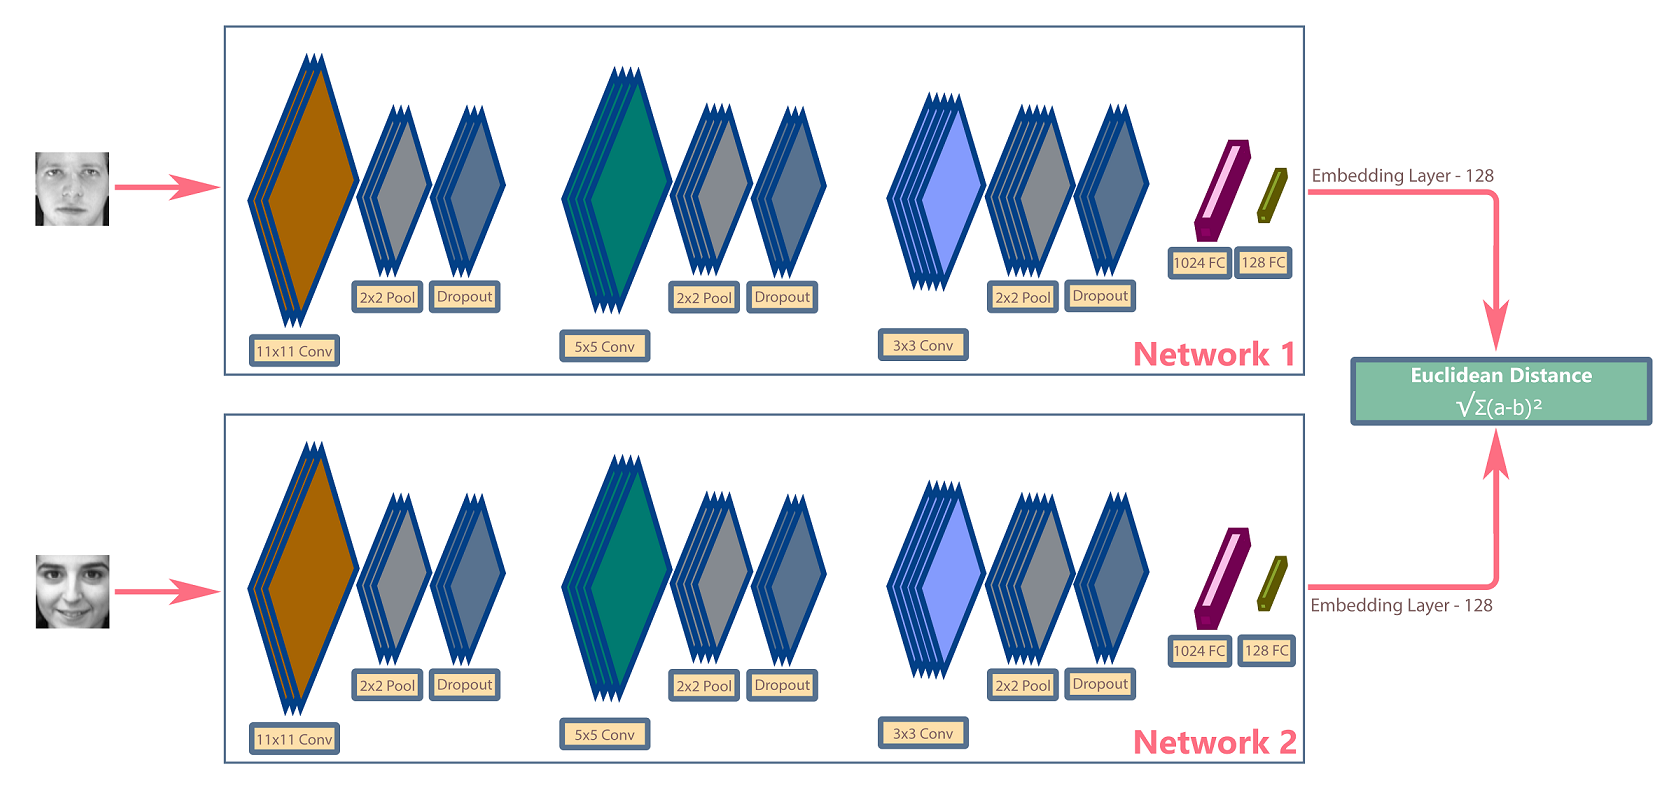

As it shows in the diagram, the pair of the networks are the same. The Siamese Network works as follows.

- To train a Siamese Network, a pair of images are picked from the dataset, each one processed by one of the networks above. (In next few sections, we will see how to generate pairs of images from the dataset.)
- The networks have the same structure, hence the same operations will be performed on the respective images.
- The Neural Networks at the end have Fully Connected Layers, with the last one consisting of 128 nodes. This layer is the final feature that gets produced when the network is applied on the image. It’s called the Embedding Layer Representation. So the two images in the pair processed by the Siamese Network produce two different Embedding Layer Representations.
- The Network then finds the Euclidean distance between both the embedding layers. If the images are of the same person, then it is expected that the embeddings will be very similar, hence distance should be smaller. However, if the images are of different people, then the distance is expected to be a higher value.
- A Sigmoid Function is applied on the distance value to bring it to 0–1 range.
- A loss function is put on the sigmoid result, to penalize the network to update its weights and the biases. we are using Binary Cross Entropy for the loss function. Updation of the weights and the biases done on both the networks are exactly the same.

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout,Conv2D,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras import backend as K
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

# **Model Implementation:**

In [ ]:
def create_model():
    inputs = Input((64, 64, 1))
    x = Conv2D(128, (11, 11), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(256, (5, 5), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(512, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    pooledOutput = GlobalAveragePooling2D()(x)
    pooledOutput = Dense(1024)(pooledOutput)
    outputs = Dense(128)(pooledOutput)

    model = Model(inputs, outputs)
    return model

- The network takes images of shape 64x64.
- Then there are three batches of Conv-Pool-Dropout present in the network (as shown in the image above).
- The network ends with the 128 node Fully Connected Embedding Layer Representation.

In [ ]:
feature_extractor = create_model()
imgA = Input(shape=(64, 64, 1))
imgB = Input(shape=(64, 64, 1))
featA = feature_extractor(imgA)
featB = feature_extractor(imgB)

- The fact that the network uses the same structure twice with two different images, it actually can be achieved with a single instance of the network. With this the parameter updating also becomes easier, as the weights and the biases will be updated in the same instance only.
- Two images are provided to the network, and the network produces the embedding layers or the features, hence the network also acts as a Feature Extractor.


In [ ]:
import tensorflow.keras.backend as K 
def euclidean_distance(vectors):
    (featA, featB) = vectors
    sum_squared = K.sum(K.square(featA - featB), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_squared, K.epsilon()))

distance = Lambda(euclidean_distance)([featA, featB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

- The Euclidean distance is calculated by finding out the square root of the sum of the squares of the difference of both the embeddings. Lambda API is used from TensorFlow Layers for this purpose. The distance value is adjusted to a range of 0–1 using Sigmoid.

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

**Olivetti Dataset for the faces**

Before diving in further into how we generate image pairs, we will look into what Dataset we are using. For my Face Recognition system, I’m using the Olivetti dataset fetched from sklearn datasets API. It has a total of 400 face images for 40 people with 10 images per person.

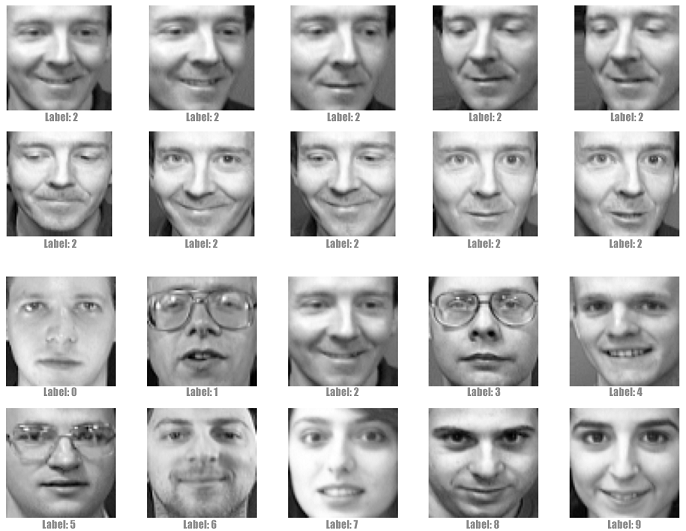

It has ids as the labels for the images. The Olivetti face dataset has the following features.

- All the images have only the faces cropped in, even the ears have been cut out.
- The images are gray scaled. And it seems the contrast and the brightness are adjusted in them.
- A person has around 10 images, each one with possibly a different face expression.

**Generating Image Pairs for Training**

Unlike a Regular CNN, here we don’t generate one image at a time, rather we generate a pair of images from the dataset.

In [ ]:
def generate_train_image_pairs(images_dataset, labels_dataset):
    unique_labels = np.unique(labels_dataset)
    label_wise_indices = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels_dataset) if
                                       label == curr_label])
    
    pair_images = []
    pair_labels = []
    for index, image in enumerate(images_dataset):
        pos_indices = label_wise_indices.get(labels_dataset[index])
        pos_image = images_dataset[np.random.choice(pos_indices)]
        pair_images.append((image, pos_image))
        pair_labels.append(1)

        neg_indices = np.where(labels_dataset != labels_dataset[index])
        neg_image = images_dataset[np.random.choice(neg_indices[0])]
        pair_images.append((image, neg_image))
        pair_labels.append(0)
    return np.array(pair_images), np.array(pair_labels)

- An image can be paired up with another image of the same label making a positive pair, or with another image of a different label making a negative pair.
- The code above starts with collecting the indices for each label.
- Then it iterates over the images dataset, and pairs up each image with a random image of the same label as a positive pair, and a random image of any other label as a negative pair.

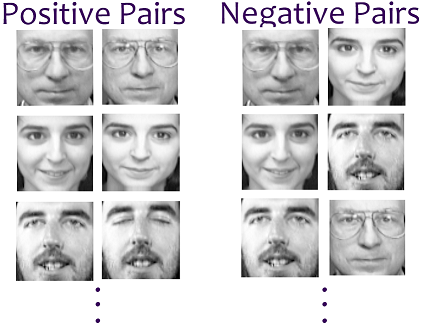

This is some sample image pairs generated from the method above. The method generates two image pairs for each image in the dataset. i.e. for each image it generates a positive pair and a negative pair. Hence, a total of 800 image pairs will be generated and used for Model training.



In [ ]:
# Imports
from sklearn.datasets import fetch_olivetti_faces
import numpy as np


In [ ]:
# Download Olivetti faces dataset
olivetti = fetch_olivetti_faces()
x = olivetti.images
y = olivetti.target

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


In [ ]:
# Print info on shapes and reshape where necessary
print("Original x shape:", x.shape)
X = x.reshape((400, 4096))
print("New x shape:", X.shape)
print("y shape", y.shape)

Original x shape: (400, 64, 64)
New x shape: (400, 4096)
y shape (400,)


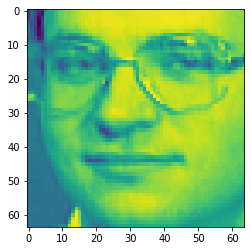

In [ ]:
plt.imshow(x[58])

**Model Training**

So we are done with the model structure and the training image generation part. Now, we start with the actual training using the generated image pairs.



In [ ]:

images_pair, labels_pair = generate_train_image_pairs(x, y)
history = model.fit([images_pair[:, 0], images_pair[:, 1]], labels_pair[:],validation_split=0.1,batch_size=64,epochs=100)


Epoch 1/100
12/12 [==============================] - 16s 190ms/step - loss: 0.6677 - accuracy: 0.5000 - val_loss: 0.6215 - val_accuracy: 0.5625
Epoch 2/100
12/12 [==============================] - 1s 105ms/step - loss: 0.6416 - accuracy: 0.5000 - val_loss: 0.6123 - val_accuracy: 0.5750
Epoch 3/100
12/12 [==============================] - 1s 106ms/step - loss: 0.6357 - accuracy: 0.5000 - val_loss: 0.5946 - val_accuracy: 0.6000
Epoch 4/100
12/12 [==============================] - 1s 105ms/step - loss: 0.6293 - accuracy: 0.5139 - val_loss: 0.5919 - val_accuracy: 0.5750
Epoch 5/100
12/12 [==============================] - 1s 104ms/step - loss: 0.6308 - accuracy: 0.5194 - val_loss: 0.5696 - val_accuracy: 0.5750
Epoch 6/100
12/12 [==============================] - 1s 106ms/step - loss: 0.6380 - accuracy: 0.5542 - val_loss: 0.5653 - val_accuracy: 0.6375
Epoch 7/100
12/12 [==============================] - 1s 105ms/step - loss: 0.6255 - accuracy: 0.5611 - val_loss: 0.5868 - val_accuracy: 0.637

**Model Performance**

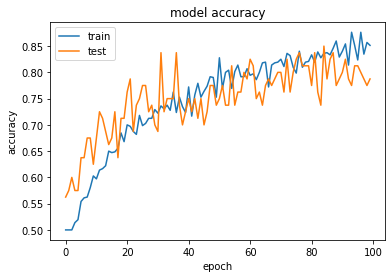

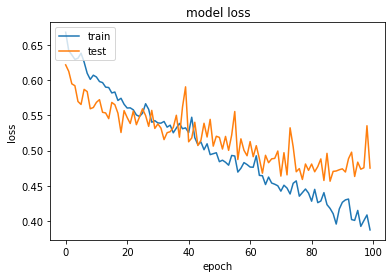

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()